#import libraries

In [102]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping



#Load data

In [103]:
import pandas as pd
path="..//content/weather_prediction_dataset.csv"
df = pd.read_csv(path, parse_dates=['DATE'], index_col='DATE')
df.dropna(inplace=True)
print(df.head())

            MONTH  BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
DATE                                                                   
2000-01-01      1                  8            0.89          1.0286   
2000-01-02      1                  8            0.87          1.0318   
2000-01-03      1                  5            0.81          1.0314   
2000-01-04      1                  7            0.79          1.0262   
2000-01-05      1                  5            0.90          1.0246   

            BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
DATE                                                                      
2000-01-01                    0.20                 0.03             0.0   
2000-01-02                    0.25                 0.00             0.0   
2000-01-03                    0.50                 0.00             3.7   
2000-01-04                    0.63                 0.35             6.9   
2000-01-05                    0.51           

# Get the best 5 features in the train to predict the TOURS_temp_max of the next day

**Use correlation analysis to select the 5 best features**

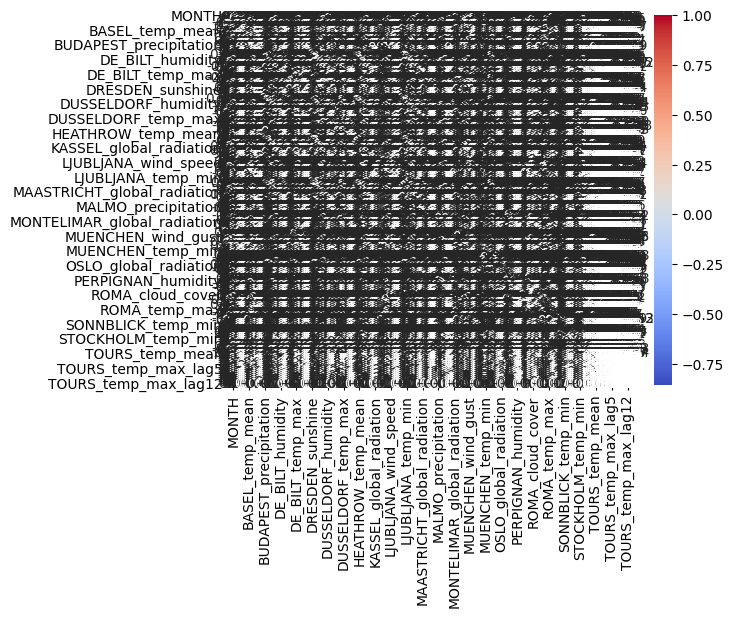

In [104]:
# Create a lagged dataset with previous day's data
# lags = avg of the 3 steps

lags = int(round(np.average([5, 10, 20])))
for i in range(1, lags+1):
    df[f'TOURS_temp_max_lag{i}'] = df['TOURS_temp_max'].shift(i)


# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Select the top n features with highest correlation with the target variable
n = 5
best_features = corr_matrix['TOURS_temp_max'].sort_values(ascending=False)[1:n+1].index.tolist()



In [105]:
# Print the best features
print(f"The best {n} features for predicting TOURS_temp_max are: {best_features}")

The best 5 features for predicting TOURS_temp_max are: ['TOURS_temp_mean', 'MONTELIMAR_temp_max', 'MAASTRICHT_temp_max', 'TOURS_temp_max_lag1', 'BASEL_temp_max']



#Dates from 2000 to 2007 used for training your model , Dates from 2008 and 2009 used to validate your model.

In [106]:
train_data = df[df.index < '2008-01-01']
val_data = df[(df.index >= '2008-01-01') & (df.index < '2010-01-01')]

features = best_features
target = ['TOURS_temp_max']
train_data=train_data[features+target]
val_data=val_data[features+target]

In [107]:
train_data

,TOURS_temp_mean,MONTELIMAR_temp_max,MAASTRICHT_temp_max,TOURS_temp_max_lag1,BASEL_temp_max,TOURS_temp_max
DATE,,,,,,
2000-01-13,1.5,7.5,3.3,2.0,5.0,3.6
2000-01-14,3.6,9.0,3.4,3.6,3.8,6.1
2000-01-15,3.5,7.9,5.1,6.1,1.5,5.9
2000-01-16,1.4,3.4,5.0,5.9,1.8,2.7
2000-01-17,3.6,7.0,7.1,2.7,4.2,6.3
...,...,...,...,...,...,...
2007-12-27,6.2,6.6,6.3,5.1,2.3,8.8
2007-12-28,5.2,4.4,8.4,8.8,1.4,6.8
2007-12-29,6.1,10.0,6.7,6.8,3.5,9.3


In [108]:
val_data 

,TOURS_temp_mean,MONTELIMAR_temp_max,MAASTRICHT_temp_max,TOURS_temp_max_lag1,BASEL_temp_max,TOURS_temp_max
DATE,,,,,,
2008-01-01,2.7,5.5,4.0,6.1,0.9,4.5
2008-01-02,1.3,8.1,0.1,4.5,-0.8,3.8
2008-01-03,3.6,11.2,1.6,3.8,3.2,7.1
2008-01-04,8.0,8.4,7.6,7.1,2.3,10.0
2008-01-05,9.4,10.0,8.6,10.0,11.6,10.9
...,...,...,...,...,...,...
2009-12-27,4.6,10.2,4.8,6.4,5.5,9.7
2009-12-28,6.2,6.6,4.1,9.7,4.8,10.6
2009-12-29,10.4,12.7,8.4,10.6,10.0,14.5


# The input and output sequences for each model according to step size 

In [113]:
def create_sequences(data, step):
    X = []
    y = []
    for i in range(len(data)-step-1):
        X.append(data[i:(i+step), :])
        y.append(data[i+step, 0])
    return np.array(X), np.array(y)


In [110]:
steps = [5, 10, 20]
# input and output sequences for each model with difrent step sizes
#for step in steps:
    #train_seq, train_label = create_sequences(train_data.values, step)
    #val_seq, val_label = create_sequences(val_data.values, step)


#Same hyperparameters for each model

In [111]:
def create_rnn_model(step):
    model = Sequential()
    model.add(SimpleRNN(64, input_shape=(step, 6)))
    model.add(Dense(1))
    return model

def create_lstm_model(step):
    model = Sequential()
    model.add(LSTM(64, input_shape=(step, 6)))
    model.add(Dense(1))
    return model

def create_gru_model(step):
    model = Sequential()
    model.add(GRU(64, input_shape=(step, 6)))
    model.add(Dense(1))
    return model


# Training

3. Use Keras to train the three models RNN, GRU and LSTM on your data using MSE loss function.

4. To determine at which epoch the training should be stopped and to avoid overfitting, apply early stopping using validation data loss.

5. For each model, try 3 different step sizes and compare their loss. Make sure that the selected step sizes are sparse and different from each other to see how the models will behave for small, medium and large step sizes.

In [121]:
epochs = 100
batch_size = 32
patience=5
# Define early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

results = pd.DataFrame(columns=['Step Size', 'Model', 'Validation Loss', '# of Epochs (Early Stopping Effect)'])

for step in steps:
    train_seq, train_label = create_sequences(train_data.values, step)
    val_seq, val_label = create_sequences(val_data.values, step)
    
    rnn_model = create_rnn_model(step)
    rnn_model.compile(loss='mse', optimizer='adam')
    rnn_model.fit(train_seq, train_label, epochs=epochs, batch_size=batch_size, validation_data=(val_seq, val_label), callbacks=[es])
    rnn_epochs = es.stopped_epoch + 1 if es.stopped_epoch is not None else epochs
    
    lstm_model = create_lstm_model(step)
    lstm_model.compile(loss='mse', optimizer='adam')
    lstm_model.fit(train_seq, train_label, epochs=epochs, batch_size=batch_size, validation_data=(val_seq, val_label), callbacks=[es])
    lstm_epochs = es.stopped_epoch + 1 if es.stopped_epoch is not None else epochs
    
    gru_model = create_gru_model(step)
    gru_model.compile(loss='mse', optimizer='adam')
    gru_model.fit(train_seq, train_label, epochs=epochs, batch_size=batch_size, validation_data=(val_seq, val_label), callbacks=[es])
    gru_epochs = es.stopped_epoch + 1 if es.stopped_epoch is not None else epochs
    
    rnn_loss = rnn_model.evaluate(val_seq, val_label)
    lstm_loss = lstm_model.evaluate(val_seq, val_label)
    gru_loss = gru_model.evaluate(val_seq, val_label)
    
    results = results.append({'Step Size': step, 'Model': 'RNN', 'Validation Loss': rnn_loss, '# of Epochs (Early Stopping Effect)': rnn_epochs}, ignore_index=True)
    results = results.append({'Step Size': step, 'Model': 'LSTM', 'Validation Loss': lstm_loss, '# of Epochs (Early Stopping Effect)': lstm_epochs}, ignore_index=True)
    results = results.append({'Step Size': step, 'Model': 'GRU', 'Validation Loss': gru_loss, '# of Epochs (Early Stopping Effect)': gru_epochs}, ignore_index=True)






Epoch 1/100
91/91 [==============================] - 2s 9ms/step - loss: 86.8940 - val_loss: 35.8079
Epoch 2/100
91/91 [==============================] - 1s 7ms/step - loss: 28.9041 - val_loss: 16.7037
Epoch 3/100
91/91 [==============================] - 1s 7ms/step - loss: 15.1453 - val_loss: 9.3035
Epoch 4/100
91/91 [==============================] - 1s 7ms/step - loss: 9.5606 - val_loss: 6.4710
Epoch 5/100
91/91 [==============================] - 1s 7ms/step - loss: 7.1814 - val_loss: 5.2068
Epoch 6/100
91/91 [==============================] - 1s 10ms/step - loss: 6.0339 - val_loss: 4.6592
Epoch 7/100
91/91 [==============================] - 1s 12ms/step - loss: 5.3324 - val_loss: 4.3640
Epoch 8/100
91/91 [==============================] - 1s 9ms/step - loss: 4.9368 - val_loss: 4.2793
Epoch 9/100
91/91 [==============================] - 1s 7ms/step - loss: 4.7354 - val_loss: 4.0991
Epoch 10/100
91/91 [==============================] - 1s 7ms/step - loss: 4.5069 - val_loss: 4.0460
Ep

<ipython-input-121-0a13ed6296d1>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Step Size': step, 'Model': 'RNN', 'Validation Loss': rnn_loss, '# of Epochs (Early Stopping Effect)': rnn_epochs}, ignore_index=True)
<ipython-input-121-0a13ed6296d1>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Step Size': step, 'Model': 'LSTM', 'Validation Loss': lstm_loss, '# of Epochs (Early Stopping Effect)': lstm_epochs}, ignore_index=True)
<ipython-input-121-0a13ed6296d1>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Step Size': step, 'Model': 'GRU', 'Validation Loss': gru_loss, '# of Epochs (Early Stopping Effect)': gru_epochs}, ignore_index=True

91/91 [==============================] - 3s 13ms/step - loss: 91.1025 - val_loss: 37.7322
Epoch 2/100
91/91 [==============================] - 1s 9ms/step - loss: 30.2448 - val_loss: 17.6919
Epoch 3/100
91/91 [==============================] - 1s 9ms/step - loss: 15.9399 - val_loss: 9.9914
Epoch 4/100
91/91 [==============================] - 1s 10ms/step - loss: 9.9741 - val_loss: 6.6253
Epoch 5/100
91/91 [==============================] - 1s 10ms/step - loss: 7.4192 - val_loss: 5.1827
Epoch 6/100
91/91 [==============================] - 1s 10ms/step - loss: 6.2106 - val_loss: 4.8139
Epoch 7/100
91/91 [==============================] - 1s 11ms/step - loss: 5.5304 - val_loss: 4.2086
Epoch 8/100
91/91 [==============================] - 1s 10ms/step - loss: 5.0604 - val_loss: 4.0688
Epoch 9/100
91/91 [==============================] - 1s 10ms/step - loss: 4.7099 - val_loss: 4.3188
Epoch 10/100
91/91 [==============================] - 1s 10ms/step - loss: 4.5328 - val_loss: 3.9587
Epoch 11

<ipython-input-121-0a13ed6296d1>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Step Size': step, 'Model': 'RNN', 'Validation Loss': rnn_loss, '# of Epochs (Early Stopping Effect)': rnn_epochs}, ignore_index=True)
<ipython-input-121-0a13ed6296d1>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Step Size': step, 'Model': 'LSTM', 'Validation Loss': lstm_loss, '# of Epochs (Early Stopping Effect)': lstm_epochs}, ignore_index=True)
<ipython-input-121-0a13ed6296d1>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Step Size': step, 'Model': 'GRU', 'Validation Loss': gru_loss, '# of Epochs (Early Stopping Effect)': gru_epochs}, ignore_index=True

91/91 [==============================] - 3s 17ms/step - loss: 88.9050 - val_loss: 38.8806
Epoch 2/100
91/91 [==============================] - 1s 15ms/step - loss: 30.7220 - val_loss: 17.9312
Epoch 3/100
91/91 [==============================] - 2s 18ms/step - loss: 16.0353 - val_loss: 9.8064
Epoch 4/100
91/91 [==============================] - 2s 24ms/step - loss: 10.0490 - val_loss: 6.5626
Epoch 5/100
91/91 [==============================] - 1s 15ms/step - loss: 7.4565 - val_loss: 5.2642
Epoch 6/100
91/91 [==============================] - 1s 15ms/step - loss: 6.1726 - val_loss: 4.6547
Epoch 7/100
91/91 [==============================] - 1s 15ms/step - loss: 5.4235 - val_loss: 4.3620
Epoch 8/100
91/91 [==============================] - 1s 15ms/step - loss: 4.9689 - val_loss: 4.1764
Epoch 9/100
91/91 [==============================] - 1s 16ms/step - loss: 4.7277 - val_loss: 4.0674
Epoch 10/100
91/91 [==============================] - 1s 15ms/step - loss: 4.4496 - val_loss: 4.0276
Epoch

<ipython-input-121-0a13ed6296d1>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Step Size': step, 'Model': 'RNN', 'Validation Loss': rnn_loss, '# of Epochs (Early Stopping Effect)': rnn_epochs}, ignore_index=True)
<ipython-input-121-0a13ed6296d1>:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Step Size': step, 'Model': 'LSTM', 'Validation Loss': lstm_loss, '# of Epochs (Early Stopping Effect)': lstm_epochs}, ignore_index=True)
<ipython-input-121-0a13ed6296d1>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Step Size': step, 'Model': 'GRU', 'Validation Loss': gru_loss, '# of Epochs (Early Stopping Effect)': gru_epochs}, ignore_index=True

#Your results will be recorded in a separated cell at the end of your notebook which will represent your report.

In [125]:
results

,Model,Validation Loss,# of Epochs (Early Stopping Effect)
Step Size,,,
5,RNN,4.331570,26
5,LSTM,3.871215,19
5,GRU,3.947829,16
10,RNN,3.923290,19
10,LSTM,3.775806,17
10,GRU,3.984897,22
20,RNN,4.027072,21
20,LSTM,3.776256,20
20,GRU,3.964073,18


# Write a detailed conclusion according to your results. The conclusion should summarize what model behaves best for each step size and what step size is best for each model, how the early stopping affected each model...etc.


```
# Based on the results table, we can draw the following conclusions:

```


1. For step size 5, the LSTM model achieved the lowest validation loss of 3.871215, followed closely by the GRU model with a validation loss of 3.947829. The RNN model had the highest validation loss of 4.331570. Therefore, the LSTM model performed the best for step size 5.

2. For step size 10, the LSTM model again achieved the lowest validation loss of 3.775806, followed by the RNN model with a validation loss of 3.923290 and the GRU model with a validation loss of 3.984897. Therefore, the LSTM model performed the best for step size 10 as well.

3. For step size 20, the LSTM model achieved the lowest validation loss of 3.776256, followed by the GRU model with a validation loss of 3.964073 and the RNN model with a validation loss of 4.027072. Therefore, the LSTM model performed the best for step size 20 as well.

4. In terms of the effect of early stopping, we can see that for all step sizes and models, early stopping was triggered before the maximum number of epochs was reached. This suggests that early stopping was effective in preventing overfitting and improving the generalization performance of the models.

5. Overall, the LSTM model performed the best across all step sizes, achieving the lowest validation loss for each step size. Therefore, if we had to choose one model to use for this task, the LSTM model would be the best choice.

6. In terms of step size, we can see that smaller step sizes (5 and 10) generally resulted in lower validation losses for all models. This suggests that using smaller step sizes can improve the performance of the models. However, it is important to note that smaller step sizes also result in longer sequences, which can increase the computational complexity of the models and make them more difficult to train.

In summary, the LSTM model performed the best for all step sizes, and using smaller step sizes generally resulted in better performance. Early stopping was effective in preventing overfitting and improving the generalization performance of the models.